In [8]:
import cv2
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import os
from PIL import Image

100%|██████████| 22512/22512 [05:14<00:00, 71.58it/s] 


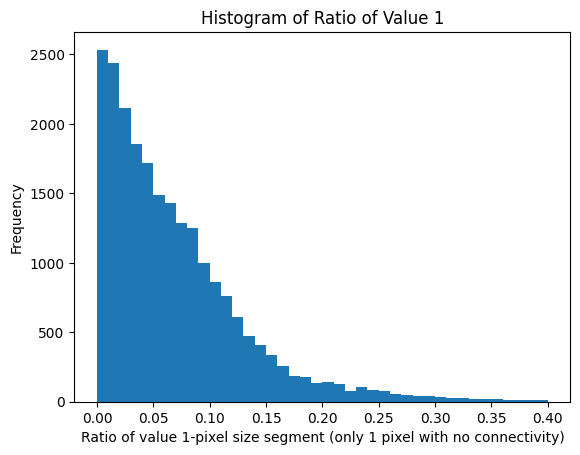

In [2]:
def calculate_ratio_histogram(image_paths):
    ratios = []
    for path in tqdm(image_paths):
        # Read the grayscale image
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        
        # Calculate the ratio of value 1 in the image
        total_pixels = image.size
        ones_pixels = (image == 1).sum()

        if ones_pixels != 0:
            ratio = ones_pixels / total_pixels
        
        ratios.append(ratio)
    
    
    # Plot the histogram
    plt.hist(ratios, bins=40, range=(0, 0.4))
    plt.xlabel('Ratio of value 1-pixel size segment (only 1 pixel with no connectivity)')
    plt.ylabel('Frequency')
    plt.title('Histogram of Ratio of Value 1')
    plt.show()

# Example usage
image_list_paths = glob("../datasets/Satellite/ann_dir/val_slice_0/*.png")
calculate_ratio_histogram(image_list_paths)

In [3]:
def visualize_images_with_masks(count, image_paths, mask_paths):
    fig, axs = plt.subplots(2, 4, figsize=(24, 14))
    fig.tight_layout()

    for i in range(8):
        image = cv2.imread(image_paths[i])
        mask = cv2.imread(mask_paths[i], cv2.IMREAD_GRAYSCALE)

        # Create a red mask for pixel label 1
        red_mask = np.zeros_like(image)
        red_mask[:, :, 0] = mask * 255  # Set the red channel to 255 where mask value is 1

        # Create a copy of the original image
        blended_image = np.copy(image)

        # Apply the red mask for pixel label 1
        blended_image[mask == 1] = cv2.addWeighted(image, 0.5, red_mask, 0.5, 0)[mask == 1]

        ax = axs[i // 4, i % 4]
        ax.imshow(blended_image.astype(np.uint8))

        ax.axis('off')

        image_title = os.path.splitext(os.path.basename(image_paths[i]))[0]
        ax.set_title(image_title, fontsize=14, pad=5)

    fig.suptitle(f"Image Count: {count}", fontsize=10)

    plt.show()

In [4]:
image_paths = glob("../datasets/Satellite/img_dir/val_slice_0/*.png")
mask_paths = glob("../datasets/Satellite/ann_dir/val_slice_0/*.png")
cnt = 296

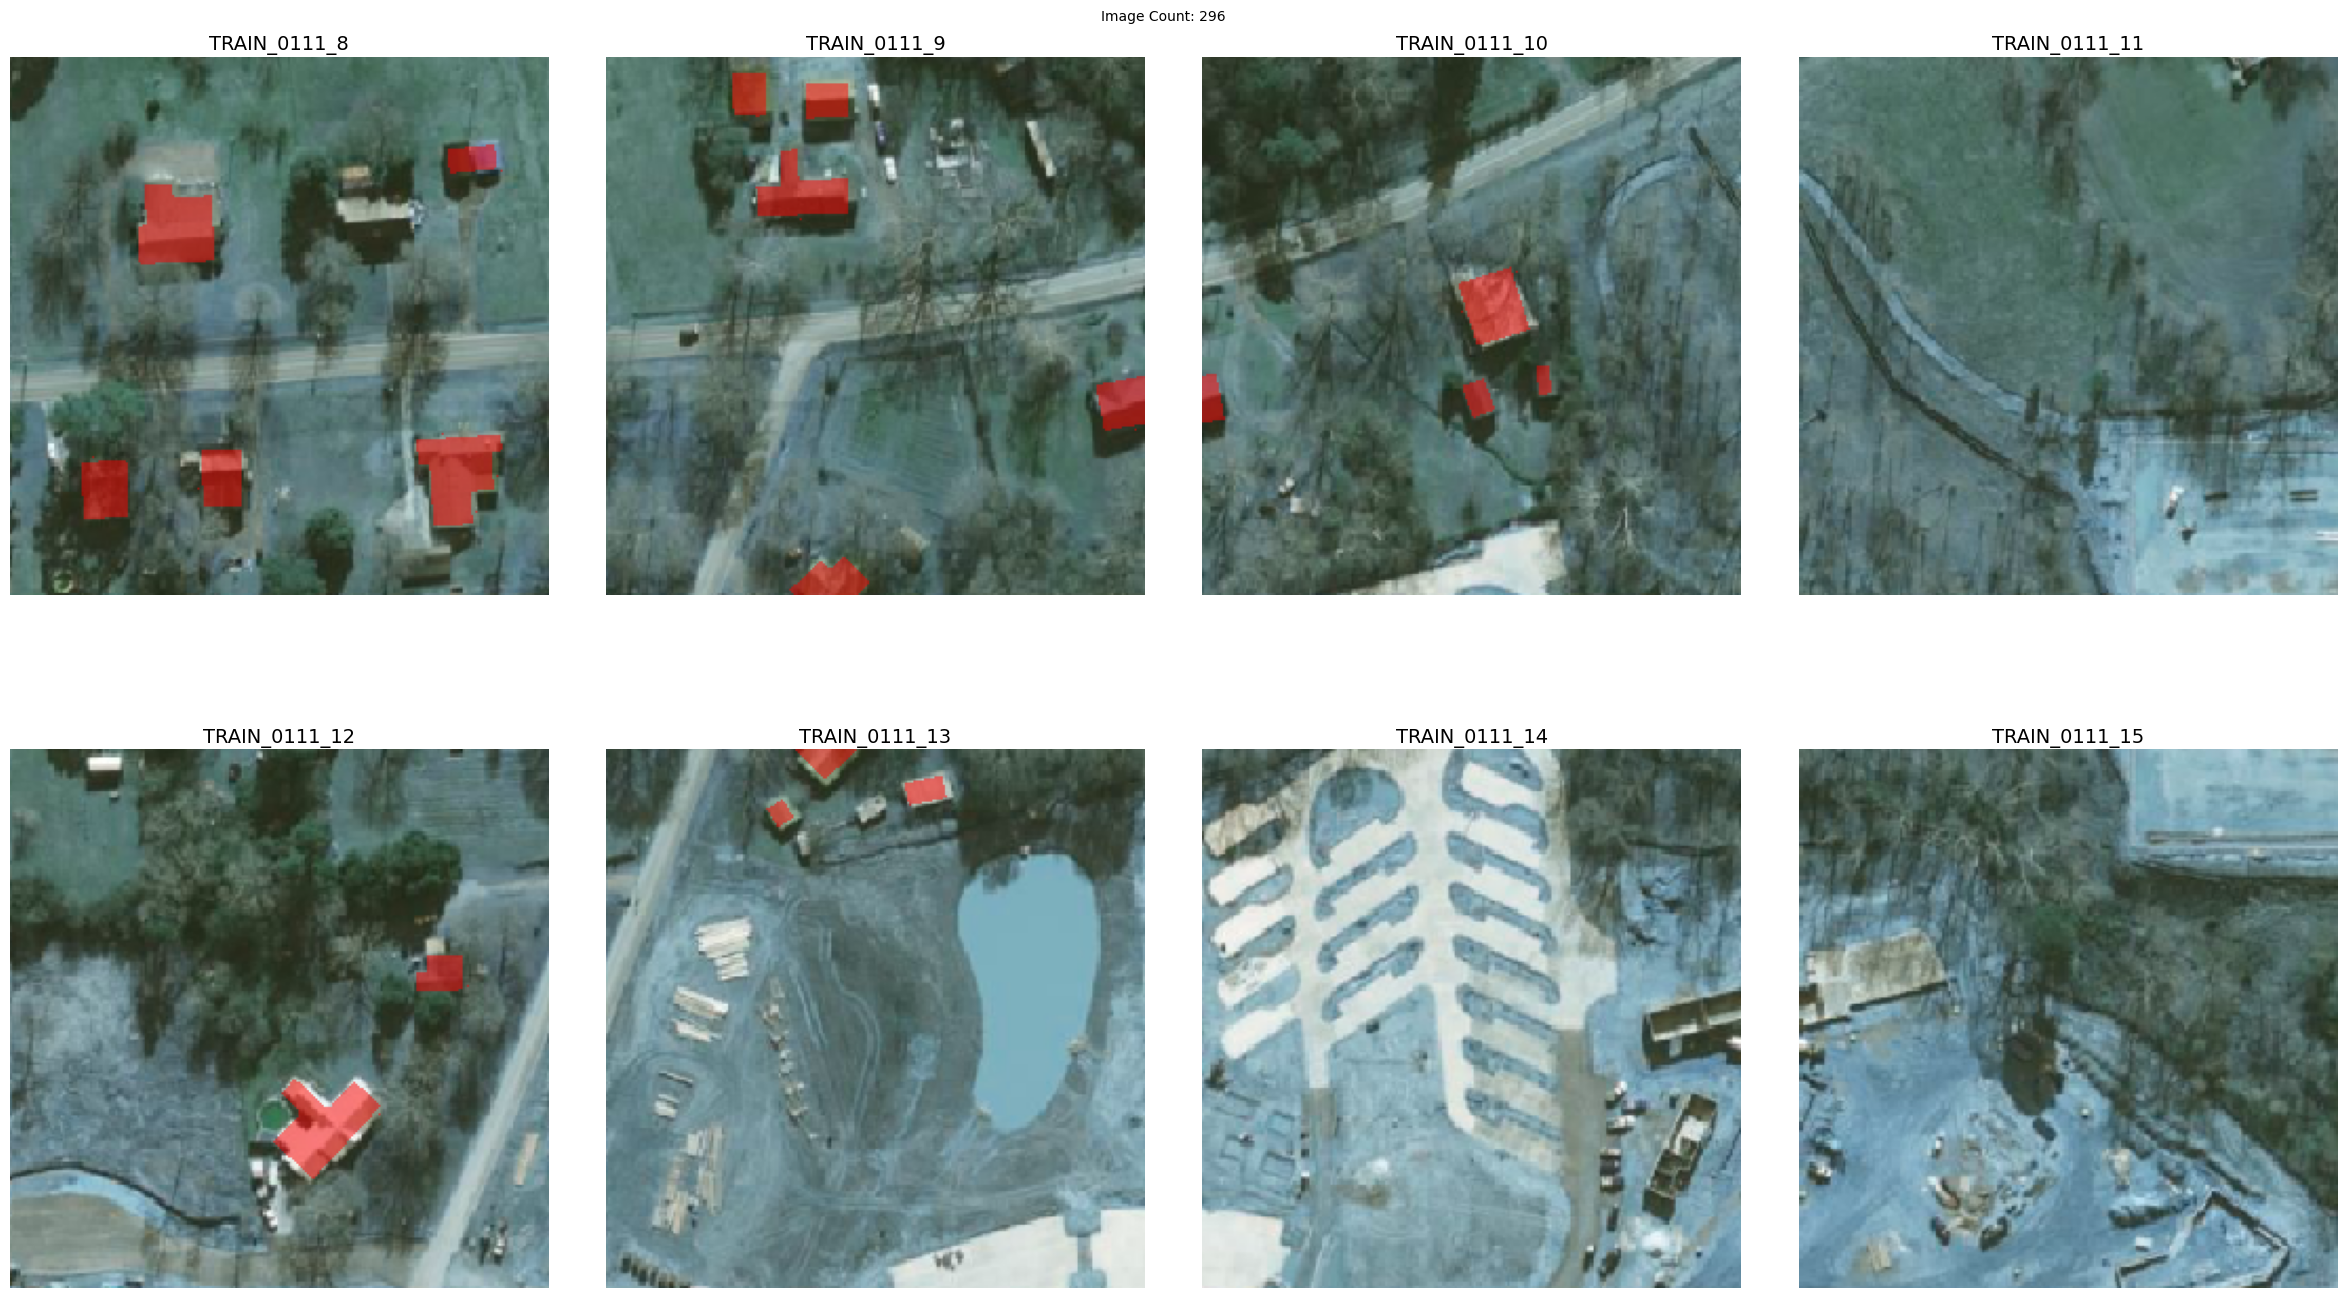

In [5]:
visualize_images_with_masks(cnt, image_paths[cnt: cnt + 8], mask_paths[cnt: cnt + 8])
cnt += 8

### Train Dataset의 RGB mean, std 분포

In [6]:
def get_img_stats(image_paths):
    """
    데이터셋에 있는 이미지들의 크기와 RGB 평균 및 표준편차를 수집하는 함수입니다.
    
    Args:
        image_paths: 학습 데이터셋 이미지 경로 

    Returns:
        img_info: 이미지들의 정보 (크기, 평균, 표준편차)
    """
    img_info = dict(heights=[], widths=[], means=[], stds=[])
    for image_path in tqdm(image_paths):
        img = np.array(Image.open(image_path))
        h, w, _ = img.shape
        img_info['heights'].append(h)
        img_info['widths'].append(w)
        img_info['means'].append(img.mean(axis=(0,1)))
        img_info['stds'].append(img.std(axis=(0,1)))
        
    return img_info

In [9]:

# train data

train_img_paths = glob("../datasets/Satellite/img_dir/train_0/*.png")

img_info = get_img_stats(train_img_paths)

print(f'Total number of imgage is {len(train_img_paths)}')

print(f'Minimum height for dataset is {np.min(img_info["heights"])}')
print(f'Maximum height for dataset is {np.max(img_info["heights"])}')
print(f'Average height for dataset is {np.mean(img_info["heights"])}')
print(f'Minimum width for dataset is {np.min(img_info["widths"])}')
print(f'Maximum width for dataset is {np.max(img_info["widths"])}')
print(f'Average width for dataset is {np.mean(img_info["widths"])}')

print(f'RGB Mean: {np.mean(img_info["means"], axis=0) / 255.}')
print(f'RGB Standard Deviation: {np.mean(img_info["stds"], axis=0) / 255.}')

  0%|          | 0/5627 [00:00<?, ?it/s]

100%|██████████| 5627/5627 [16:53<00:00,  5.55it/s]  


Total number of imgage is 5627
Minimum height for dataset is 1024
Maximum height for dataset is 1024
Average height for dataset is 1024.0
Minimum width for dataset is 1024
Maximum width for dataset is 1024
Average width for dataset is 1024.0
RGB Mean: [0.34041413 0.35612023 0.32391883]
RGB Standard Deviation: [0.1712178  0.15099189 0.13871551]
